Synthesized velocity field shape: torch.Size([3, 256, 256, 256])


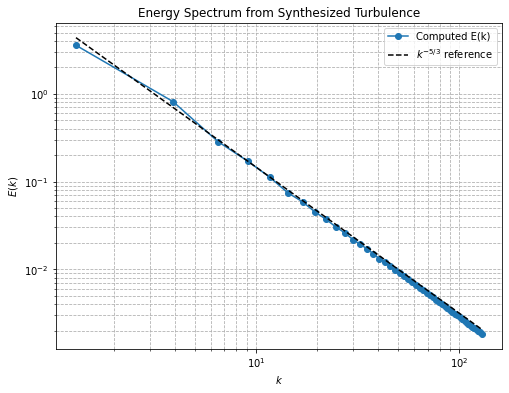

In [ ]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters and Device Setup ---
device = torch.device("cpu")  # change to "cuda" if you have a GPU
N = 256                     # Number of grid points per dimension
L = 2 * np.pi               # Domain length, so domain is [0, 2*pi]^3
dx = L / N                  # Grid spacing

# --- Step 1: Create the Fourier grid ---
# Construct 1D Fourier frequencies for x and y directions
k1d = torch.cat((torch.arange(0, N//2, device=device), torch.arange(-N//2, 0, device=device)))
# For the third direction (z) use only non-negative frequencies (for rfft)
kz = torch.arange(0, N//2 + 1, device=device)

# Create 3D grids with "ij" indexing
KX, KY, KZ = torch.meshgrid(k1d, k1d, kz, indexing='ij')
# Compute the magnitude of the wavevector (avoid division by zero later)
kmag = torch.sqrt(KX.to(torch.float32)**2 + KY.to(torch.float32)**2 + KZ.to(torch.float32)**2)
nonzero = kmag > 0  # mask to avoid k=0

# --- Step 2: Generate random Fourier coefficients with Kolmogorov scaling ---
# We generate a velocity vector field in Fourier space with shape (3, N, N, N//2+1)
shape = (3, N, N, N//2+1)
# Generate random complex numbers with independent real and imaginary parts
uhat = (torch.randn(shape, dtype=torch.complex64, device=device) +
        1j * torch.randn(shape, dtype=torch.complex64, device=device))
uhat = uhat / np.sqrt(2)  # normalization

# Kolmogorov scaling:
# In 3D, if E(k) ∝ k^(-5/3) then one common choice is to set |û(k)| ∝ k^(-11/6)
A0 = 1.0  # Overall amplitude (adjust if needed)
# Create amplitude array: note that we only scale for nonzero k
amplitude = torch.zeros_like(kmag, dtype=torch.float32)
amplitude[nonzero] = A0 * (kmag[nonzero])**(-11/6)
# Expand amplitude dimensions so it applies to each velocity component
amplitude = amplitude.unsqueeze(0)  # shape now (1, N, N, N//2+1)
uhat = uhat * amplitude

# --- Step 3: Enforce the divergence–free condition (incompressibility) ---
# Construct the 3–component wavevector K = (KX, KY, KZ)
KX = KX.to(torch.float32)
KY = KY.to(torch.float32)
KZ = KZ.to(torch.float32)
K = torch.stack((KX, KY, KZ), dim=0)  # shape (3, N, N, N//2+1)
# Compute the dot product k·û for each Fourier mode over the three velocity components
dot = (K * uhat).sum(dim=0)  # shape (N, N, N//2+1)
# Compute k^2 for each mode (with proper broadcasting)
kmag2 = kmag**2
kmag2_expanded = kmag2.unsqueeze(0)  # shape (1, N, N, N//2+1)
# Projection: subtract the component along k to enforce (k · û = 0)
projection = K * (dot / kmag2_expanded)
uhat = torch.where(kmag2_expanded > 0, uhat - projection, uhat)

# --- Step 4: Inverse FFT to Recover the Real-space Velocity Field ---
# u_field will be a real-valued field with shape (3, N, N, N)
u_field = torch.zeros((3, N, N, N), dtype=torch.float32, device=device)
for i in range(3):
    u_field[i] = torch.fft.irfftn(uhat[i], s=(N, N, N))

# Optionally normalize the field (e.g., set RMS velocity to 1)
rms = torch.sqrt((u_field**2).mean())
u_field = u_field / rms

print("Synthesized velocity field shape:", u_field.shape)

# --- Step 5: Compute the Energy Spectrum E(k) ---
# The energy PER MODE is defined as 0.5 * (|û_x|^2 + |û_y|^2 + |û_z|^2)
energy_modes = 0.5 * torch.sum(torch.abs(uhat)**2, dim=0)  # shape (N, N, N//2+1)

# Flatten the wavevector magnitudes and energy:
kmag_flat = kmag.cpu().numpy().flatten()
energy_flat = energy_modes.cpu().numpy().flatten()

# Define bins in k (spherical shells)
num_bins = 50
k_min = kmag_flat[kmag_flat > 0].min()  # exclude zero to avoid log(0)
k_max = kmag_flat.max()/1.7
bins = np.linspace(0.0, k_max, num_bins+1)  # num_bins bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
delta_k = bins[1:] - bins[:-1]

# Bin the energy using np.histogram with weights:
bin_energy, _ = np.histogram(kmag_flat, bins=bins, weights=energy_flat)
# Normalize by the bin width to obtain an estimate of the energy density E(k)
E_k = bin_energy / delta_k

# --- Step 6: Plotting the Spectrum on a Log-Log Scale ---
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, E_k, 'o-', label='Computed E(k)')

# Optionally, plot a reference line with a slope of -5/3
# We choose an arbitrary constant to align the reference line with the computed data.
ref_const = E_k[3] * (bin_centers[3]**(5/3))
plt.loglog(bin_centers, ref_const * bin_centers**(-5/3), 'k--', label=r'$k^{-5/3}$ reference')

plt.xlabel(r'$k$')
plt.ylabel(r'$E(k)$')
plt.title('Energy Spectrum from Synthesized Turbulence')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


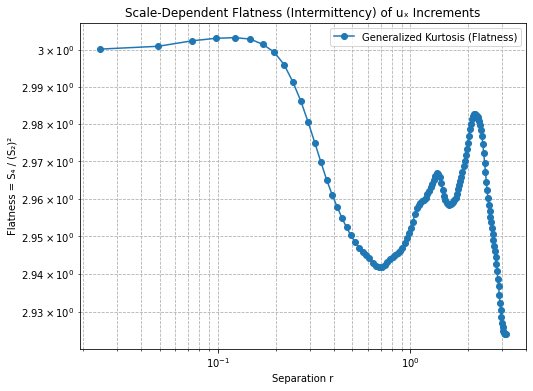

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ------------------------------
# Parameters (assumes u_field is available)
# ------------------------------
# u_field is assumed to be a torch tensor of shape (3, N, N, N) from the previous synthesis code.
# For example, u_field[0] is the x‐component.
u_field_cpu = u_field.cpu()  # move to CPU if not already
N = u_field_cpu.shape[1]
L = 2 * np.pi               # domain length [0, 2π]
dx = L / N                  # grid spacing in physical units

# ------------------------------
# Compute Structure Functions and Generalized Kurtosis
# ------------------------------
# We compute the longitudinal velocity increments along the x-direction.
# For a given separation r, we compute:
#    δu(r) = u(x + r) − u(x)
# and then average over the entire domain to get the structure functions:
#    S_p(r) = ⟨|δu(r)|^p⟩.
#
# The generalized kurtosis (for p = 4) is defined as:
#    Flatness = Γ₄(r) = S₄(r) / [S₂(r)]².

# Extract the x–component as a NumPy array.
u_x = u_field_cpu[0].numpy()  # shape (N, N, N)

max_shift = N // 2           # use up to half the domain to avoid finite-size artifacts
num_lags = max_shift         # lags index from 1 to max_shift
lags = np.arange(1, num_lags + 1) * dx  # physical separation distances

S2 = np.zeros(num_lags)
S4 = np.zeros(num_lags)

# Loop over various lag distances (shifts) along the x-axis.
for n in range(1, num_lags + 1):
    # Compute increments with a periodic (circular) shift in the x-direction.
    # np.roll handles the periodicity.
    delta_u = u_x - np.roll(u_x, shift=-n, axis=0)
    # Compute the 2nd-order structure function: S₂(n*dx)
    S2[n - 1] = np.mean(delta_u**2)
    # Compute the 4th-order structure function: S₄(n*dx)
    S4[n - 1] = np.mean(delta_u**4)

# Compute generalized kurtosis (flatness).
flatness = S4 / (S2**2)

# ------------------------------
# Plotting the Generalized Kurtosis (Intermittency)
# ------------------------------
plt.figure(figsize=(8, 6))
plt.loglog(lags, flatness, 'o-', label='Generalized Kurtosis (Flatness)')
plt.xlabel('Separation r')
plt.ylabel('Flatness = S₄ / (S₂)²')
plt.title('Scale-Dependent Flatness (Intermittency) of uₓ Increments')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Inclusion of a multifractal model to account for intermittency.

Gaussian-synthesized velocity field shape: torch.Size([3, 256, 256, 256])


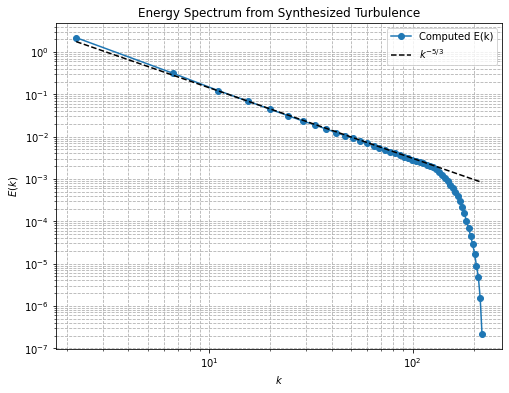

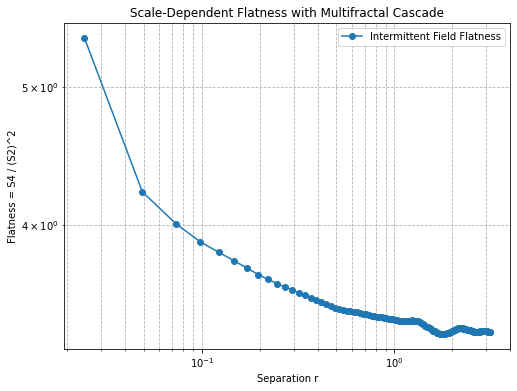

In [3]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# PART 1: Synthesize Gaussian Turbulence
# ==============================
device = torch.device("cpu")
N = 256            # grid points per dimension (assumed 2**8)
L = 2 * np.pi
dx = L / N

# --- Create Fourier grid ---
k1d = torch.cat((torch.arange(0, N//2, device=device),
                 torch.arange(-N//2, 0, device=device)))
kz = torch.arange(0, N//2+1, device=device)
KX, KY, KZ = torch.meshgrid(k1d, k1d, kz, indexing='ij')
kmag = torch.sqrt(KX.to(torch.float32)**2 + KY.to(torch.float32)**2 + KZ.to(torch.float32)**2)
nonzero = kmag > 0

# --- Generate Fourier coefficients with Kolmogorov scaling ---
shape = (3, N, N, N//2+1)
uhat = (torch.randn(shape, dtype=torch.complex64, device=device) + 
        1j * torch.randn(shape, dtype=torch.complex64, device=device))
uhat = uhat / np.sqrt(2)
# Kolmogorov scaling: |û(k)| ∝ k^(-11/6) gives E(k) ∝ k^(-5/3)
A0 = 1.0
amplitude = torch.zeros_like(kmag, dtype=torch.float32)
amplitude[nonzero] = A0 * (kmag[nonzero])**(-11/6)
amplitude = amplitude.unsqueeze(0)  # shape (1, N, N, N//2+1)
uhat = uhat * amplitude

# --- Enforce Incompressibility ---
KX = KX.to(torch.float32)
KY = KY.to(torch.float32)
KZ = KZ.to(torch.float32)
K = torch.stack((KX, KY, KZ), dim=0)
dot = (K * uhat).sum(dim=0)
kmag2 = kmag**2
kmag2_expanded = kmag2.unsqueeze(0)
projection = K * (dot / kmag2_expanded)
uhat = torch.where(kmag2_expanded > 0, uhat - projection, uhat)

# --- Inverse Fourier Transform ---
u_field = torch.zeros((3, N, N, N), dtype=torch.float32, device=device)
for i in range(3):
    u_field[i] = torch.fft.irfftn(uhat[i], s=(N, N, N))
# Optional normalization: set RMS velocity to 1
rms = torch.sqrt((u_field**2).mean())
u_field = u_field / rms

print("Gaussian-synthesized velocity field shape:", u_field.shape)

# ==============================
# PART 2: Generate a Multifractal Cascade Field
# ==============================
# Here we build a simple dyadic multiplicative cascade over the same (N,N,N) grid.
# The idea is to multiply, at each dyadic scale, by a random factor drawn from a lognormal distribution.
# This process is known to produce intermittent multifractal measures.

def generate_multifractal_cascade(N, lambda_sq):
    """
    Generate a multiplicative cascade field on a cubic grid.
    N should be a power of 2.
    
    Parameters:
      N         : grid resolution in one dimension.
      lambda_sq : variance parameter for the log-normal multipliers.
      
    Returns:
      A numpy array of shape (N,N,N) with mean 1.
    """
    cascade = np.ones((N, N, N), dtype=np.float32)
    levels = int(np.log2(N))  # number of dyadic subdivisions
    for level in range(levels):
        block_size = N // (2**level)
        # Loop over blocks at this level:
        for i in range(0, N, block_size):
            for j in range(0, N, block_size):
                for k in range(0, N, block_size):
                    sigma = np.sqrt(lambda_sq)
                    # Draw a multiplier from a lognormal distribution with unit mean
                    m = np.exp(sigma * np.random.randn() - lambda_sq/2)
                    cascade[i:i+block_size, j:j+block_size, k:k+block_size] *= m
    # Normalize the cascade field to have mean 1.
    cascade = cascade / np.mean(cascade)
    return cascade

# Choose an intermittency parameter (adjust lambda_sq to tune the degree of intermittency)
lambda_sq = 0.01
cascade_field = generate_multifractal_cascade(N, lambda_sq)  # shape (N, N, N)

# ==============================
# PART 3: Modulate the Velocity Field with the Cascade
# ==============================
# Convert the synthetic velocity field (u_field) to a numpy array.
u_field_np = u_field.cpu().numpy()  # shape (3, N, N, N)
# Multiply each velocity component by the cascade field.
u_field_int = np.empty_like(u_field_np)
for comp in range(3):
    u_field_int[comp] = u_field_np[comp] * cascade_field

# At this point u_field_int is our intermittent velocity field.
# (Note: The multiplication modifies the amplitudes and introduces intermittency but may slightly break
# the strict divergence-free condition. For synthetic studies of intermittency, this is often acceptable.)

# ==============================
# PART 4: Compute and Plot the Energy Spectrum
# ==============================
# (We compute E(k) as before from the original synthesized (Gaussian) field in Fourier space.
#  You could also recompute from u_field_int if desired, but note that multiplying in physical space 
#  will mix Fourier modes.)
energy_modes = 0.5 * torch.sum(torch.abs(uhat)**2, dim=0)
kmag_flat = kmag.cpu().numpy().flatten()
energy_flat = energy_modes.cpu().numpy().flatten()
num_bins = 50
bins = np.linspace(0.0, kmag_flat.max(), num_bins+1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
delta_k = bins[1:] - bins[:-1]
bin_energy, _ = np.histogram(kmag_flat, bins=bins, weights=energy_flat)
E_k = bin_energy / delta_k

plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, E_k, 'o-', label='Computed E(k)')
# Reference line k^(-5/3)
ref_const = E_k[3] * (bin_centers[3]**(5/3))
plt.loglog(bin_centers, ref_const * bin_centers**(-5/3), 'k--', label=r'$k^{-5/3}$')
plt.xlabel(r'$k$')
plt.ylabel(r'$E(k)$')
plt.title('Energy Spectrum from Synthesized Turbulence')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# ==============================
# PART 5: Compute Structure Functions and Generalized Kurtosis
# ==============================
# In this part we compare the intermittent (modulated) field with the Gaussian one.
# We compute structure functions for the x–component, and then compute the generalized kurtosis:
#   Flatness = S4(r) / (S2(r))^2.
# Since the multifractal cascade has been applied, we expect the flatness to grow for small r.
# (For a pure Gaussian field, the flatness is 3 over all scales.)

# We use the x-component of the modulated field.
u_x_int = u_field_int[0]  # shape (N, N, N)
max_shift = N // 2
num_lags = max_shift
lags = np.arange(1, num_lags + 1) * dx

S2_int = np.zeros(num_lags)
S4_int = np.zeros(num_lags)

for n in range(1, num_lags + 1):
    # Compute increments along the x-direction using periodic shift.
    delta_u = u_x_int - np.roll(u_x_int, shift=-n, axis=0)
    S2_int[n - 1] = np.mean(delta_u**2)
    S4_int[n - 1] = np.mean(delta_u**4)

flatness_int = S4_int / (S2_int**2)

plt.figure(figsize=(8, 6))
plt.loglog(lags, flatness_int, 'o-', label='Intermittent Field Flatness')
plt.xlabel('Separation r')
plt.ylabel('Flatness = S4 / (S2)^2')
plt.title('Scale-Dependent Flatness with Multifractal Cascade')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Plot a slice.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters and grid definitions
# -----------------------------
N = 256             # grid resolution in one dimension
L = 2 * np.pi       # domain length
dx = L / N          # grid spacing
z_index = N // 2    # fixed z-plane (central slice)

# Convert the Gaussian field (u_field) from Torch tensor to NumPy array.
# u_field_int is assumed to be already a NumPy array.
u_field_gauss = u_field.cpu().numpy()

# -----------------------------
# Function to compute ωₓ (vorticity x-component) from a 3D velocity field
# -----------------------------
def compute_omega_x(u_field, dx):
    # u_field shape: (3, N, N, N) with components [u_x, u_y, u_z].
    u_x = u_field[0]
    u_y = u_field[1]
    u_z = u_field[2]
    # Use finite differences with np.gradient.
    grad_u_y = np.gradient(u_y, dx, edge_order=2)  # [du_y/dx, du_y/dy, du_y/dz]
    grad_u_z = np.gradient(u_z, dx, edge_order=2)  # [du_z/dx, du_z/dy, du_z/dz]
    # ωₓ = ∂y u_z - ∂z u_y
    omega_x = grad_u_z[1] - grad_u_y[2]
    return omega_x

# Compute ωₓ for both fields.
omega_x_int = compute_omega_x(u_field_int, dx)
omega_x_gauss = compute_omega_x(u_field_gauss, dx)

# -----------------------------
# Helper function: extract u_x and velocity magnitude from a field at z = L/2.
# -----------------------------
def extract_slices(u_field):
    # u_field shape: (3, N, N, N)
    u_x = u_field[0, :, :, z_index]
    u_y = u_field[1, :, :, z_index]
    u_z = u_field[2, :, :, z_index]
    vel_mag = np.sqrt(u_x**2 + u_y**2 + u_z**2)
    return u_x, vel_mag

# For the intermittent field:
u_x_int, vel_mag_int = extract_slices(u_field_int)
omega_x_int_slice = omega_x_int[:, :, z_index]

# For the Gaussian field:
u_x_gauss, vel_mag_gauss = extract_slices(u_field_gauss)
omega_x_gauss_slice = omega_x_gauss[:, :, z_index]

# -----------------------------
# Create a coordinate grid for the x-y plane.
# -----------------------------
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
extent = [0, L, 0, L]  # for imshow
X, Y = np.meshgrid(x, y, indexing='ij')

# -----------------------------
# Create a figure with 2 rows and 3 columns.
# -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# --- Column Titles (set on the upper row) ---
axs[0, 0].set_title("2D Slice", fontsize=16)
axs[0, 1].set_title("Velocity Magnitude", fontsize=16)
axs[0, 2].set_title("Vorticity (ωₓ)", fontsize=16)

# --- Row 1: Intermittent Field ---
im00 = axs[0, 0].imshow(u_x_int, origin="lower", extent=extent)
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
fig.colorbar(im00, ax=axs[0, 0], orientation='vertical', label="uₓ")

im01 = axs[0, 1].imshow(vel_mag_int, origin="lower", extent=extent)
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
fig.colorbar(im01, ax=axs[0, 1], orientation='vertical', label="|u|")

im02 = axs[0, 2].imshow(omega_x_int_slice, origin="lower", extent=extent)
axs[0, 2].set_xlabel("x")
axs[0, 2].set_ylabel("y")
fig.colorbar(im02, ax=axs[0, 2], orientation='vertical', label="ωₓ")

# --- Row 2: Gaussian Field ---
im10 = axs[1, 0].imshow(u_x_gauss, origin="lower", extent=extent)
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
fig.colorbar(im10, ax=axs[1, 0], orientation='vertical', label="uₓ")

im11 = axs[1, 1].imshow(vel_mag_gauss, origin="lower", extent=extent)
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
fig.colorbar(im11, ax=axs[1, 1], orientation='vertical', label="|u|")

im12 = axs[1, 2].imshow(omega_x_gauss_slice, origin="lower", extent=extent)
axs[1, 2].set_xlabel("x")
axs[1, 2].set_ylabel("y")
fig.colorbar(im12, ax=axs[1, 2], orientation='vertical', label="ωₓ")

# -----------------------------
# Add row labels on the left side for each row using fig.text
# -----------------------------
fig.text(0.02, 0.75, "Intermittent", va="center", ha="center", rotation="vertical", fontsize=18)
fig.text(0.02, 0.32, "Gaussian", va="center", ha="center", rotation="vertical", fontsize=18)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


Wavelet approach.

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from numpy.fft import fftn, fftshift

# -----------------------------
# Parameters for the synthesis
# -----------------------------
N = 256            # grid resolution (assumed power of 2)
L = 2 * np.pi      # physical domain size [0, L]^3
dx = L / N         # grid spacing
H = 1/3.0          # Hurst exponent for turbulence (velocity increments ~ r^(1/3))
lambda_sq = 0.02   # intermittency parameter for multifractal modulation
sigma = np.sqrt(lambda_sq)

wavelet = pywt.Wavelet('db2')
# Determine maximum decomposition level for our grid
max_level = pywt.dwt_max_level(N, wavelet.dec_len)
levels = max_level  # we use all available levels

# -----------------------------
# Generate Wavelet Coefficients with Multifractal Scaling
# -----------------------------
# The pywt.wavedecn() function returns a list of coefficients:
#    coeffs[0] is the approximation coefficients (at the coarsest scale),
#    coeffs[1:] are detail coefficients at each level (each a dict).
# We first build a template (of zeros) to know the shapes.
dummy = np.zeros((N, N, N))
coeffs_template = pywt.wavedecn(dummy, wavelet, level=levels)

# Initialize new coefficients list
coeffs = []

# For the approximation (coarsest scale) -- use a scaling corresponding to scale = 2^(-levels*(H+0.5))
scale_approx = 2**(-levels*(H + 0.5))
# Generate random coefficients with an intermittent multiplier: here we use a lognormal multiplier.
approx_coeff = scale_approx * (np.exp(sigma * np.random.randn(*coeffs_template[0].shape) - (sigma**2)/2)) \
                        * np.random.randn(*coeffs_template[0].shape)
coeffs.append(approx_coeff)

# For each detail level j = 1,2,...,levels:
for j in range(1, levels + 1):
    detail_level = {}
    # Here we assume that the characteristic scale for level j is 2^(-j) relative to the full size.
    # For an orthonormal wavelet, detail coefficients for a fractional Brownian motion scale as 2^{-j*(H+1/2)}.
    scale_j = 2**(-j*(H + 0.5))
    for key, arr in coeffs_template[j].items():
        # Generate a random array with the shape of this subband and multiply by a lognormal multiplier.
        mult = np.exp(sigma * np.random.randn(*arr.shape) - (sigma**2)/2)
        detail_level[key] = scale_j * mult * np.random.randn(*arr.shape)
    coeffs.append(detail_level)

# -----------------------------
# Reconstruct the 3D Field from Wavelet Coefficients
# -----------------------------
# This gives us a synthetic scalar field (e.g., one velocity component).
u_field_wave = pywt.waverecn(coeffs, wavelet)
# Sometimes the reconstruction might be slightly larger than N; we crop if necessary.
u_field_wave = u_field_wave[:N, :N, :N]

# Normalize the field (set RMS=1)
rms_wave = np.sqrt(np.mean(u_field_wave**2))
u_field_wave = u_field_wave / rms_wave

# -----------------------------
# Compute Energy Spectrum of the Synthesized Field
# -----------------------------
# Compute the Fourier transform of the field.
U_k = fftn(u_field_wave)
U_k = fftshift(U_k)  # shift zero frequency to center
E_k_3d = (np.abs(U_k)**2) / (N**3)  # energy density

# Create a radial wavenumber grid
kx = np.fft.fftfreq(N, d=dx)
kx = fftshift(kx)
ky = kx.copy()
kz = kx.copy()  # same as kx for uniform grid
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
k_rad = np.sqrt(KX**2 + KY**2 + KZ**2).flatten()
E_k_3d = E_k_3d.flatten()

# Bin the energy in radial shells
num_bins = 50
bins = np.linspace(0, k_rad.max(), num_bins+1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
E_bins, _ = np.histogram(k_rad, bins=bins, weights=E_k_3d)
counts, _ = np.histogram(k_rad, bins=bins)
E_spectrum = E_bins / counts

# -----------------------------
# Compute Structure Functions and Flatness
# -----------------------------
# Here we compute increments along the x-direction (for simplicity).
max_shift = N // 2
lags = np.arange(1, max_shift + 1) * dx
S2 = np.zeros(max_shift)
S4 = np.zeros(max_shift)
for n in range(1, max_shift + 1):
    delta = u_field_wave[n:, :, :] - u_field_wave[:-n, :, :]
    S2[n-1] = np.mean(delta**2)
    S4[n-1] = np.mean(delta**4)
flatness = S4 / (S2**2)

# -----------------------------
# Plot the Energy Spectrum and Flatness
# -----------------------------
plt.figure(figsize=(12, 5))

# Energy Spectrum Plot
plt.subplot(1, 2, 1)
plt.loglog(bin_centers, E_spectrum, 'o-', label='Energy Spectrum')
# Plot a reference line with slope -5/3; here we choose an arbitrary scaling to compare slope.
ref_line = E_spectrum[5] * (bin_centers / bin_centers[5])**(-5/3)
plt.loglog(bin_centers, ref_line, 'k--', label=r'$k^{-5/3}$')
plt.xlabel('k')
plt.ylabel('E(k)')
plt.title('Energy Spectrum (Wavelet Synthesis)')
plt.legend()
plt.grid(True, which='both', ls='--')

# Flatness Plot
plt.subplot(1, 2, 2)
plt.loglog(lags, flatness, 'o-', label='Flatness')
plt.xlabel('Separation r')
plt.ylabel('Flatness = S4/S2^2')
plt.title('Scale-dependent Flatness (Wavelet Synthesis)')
plt.legend()
plt.grid(True, which='both', ls='--')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters and grid definitions
# -----------------------------
N = 256             # grid resolution in one dimension
L = 2 * np.pi       # domain length
dx = L / N          # grid spacing
z_index = N // 2    # fixed z-plane (central slice)

# Convert the Gaussian field (u_field) from Torch tensor to NumPy array.
# u_field_int is assumed to be already a NumPy array.
u_field_gauss = u_field.cpu().numpy()

# -----------------------------
# Function to compute ωₓ (vorticity x-component) from a 3D velocity field
# -----------------------------
def compute_omega_x(u_field, dx):
    # u_field shape: (3, N, N, N) with components [u_x, u_y, u_z].
    u_x = u_field[0]
    u_y = u_field[1]
    u_z = u_field[2]
    # Use finite differences with np.gradient.
    grad_u_y = np.gradient(u_y, dx, edge_order=2)  # [du_y/dx, du_y/dy, du_y/dz]
    grad_u_z = np.gradient(u_z, dx, edge_order=2)  # [du_z/dx, du_z/dy, du_z/dz]
    # ωₓ = ∂y u_z - ∂z u_y
    omega_x = grad_u_z[1] - grad_u_y[2]
    return omega_x

# Compute ωₓ for both fields.
omega_x_int = compute_omega_x(u_field_int, dx)
omega_x_gauss = compute_omega_x(u_field_gauss, dx)

# -----------------------------
# Helper function: extract u_x and velocity magnitude from a field at z = L/2.
# -----------------------------
def extract_slices(u_field):
    # u_field shape: (3, N, N, N)
    u_x = u_field[0, :, :, z_index]
    u_y = u_field[1, :, :, z_index]
    u_z = u_field[2, :, :, z_index]
    vel_mag = np.sqrt(u_x**2 + u_y**2 + u_z**2)
    return u_x, vel_mag

# For the intermittent field:
u_x_int, vel_mag_int = extract_slices(u_field_int)
omega_x_int_slice = omega_x_int[:, :, z_index]

# For the Gaussian field:
u_x_gauss, vel_mag_gauss = extract_slices(u_field_gauss)
omega_x_gauss_slice = omega_x_gauss[:, :, z_index]

# -----------------------------
# Create a coordinate grid for the x-y plane.
# -----------------------------
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
extent = [0, L, 0, L]  # for imshow
X, Y = np.meshgrid(x, y, indexing='ij')

# -----------------------------
# Create a figure with 2 rows and 3 columns.
# -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# --- Column Titles (set on the upper row) ---
axs[0, 0].set_title("2D Slice", fontsize=16)
axs[0, 1].set_title("Velocity Magnitude", fontsize=16)
axs[0, 2].set_title("Vorticity (ωₓ)", fontsize=16)

# --- Row 1: Intermittent Field ---
im00 = axs[0, 0].imshow(u_x_int, origin="lower", extent=extent)
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
fig.colorbar(im00, ax=axs[0, 0], orientation='vertical', label="uₓ")

im01 = axs[0, 1].imshow(vel_mag_int, origin="lower", extent=extent)
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
fig.colorbar(im01, ax=axs[0, 1], orientation='vertical', label="|u|")

im02 = axs[0, 2].imshow(omega_x_int_slice, origin="lower", extent=extent)
axs[0, 2].set_xlabel("x")
axs[0, 2].set_ylabel("y")
fig.colorbar(im02, ax=axs[0, 2], orientation='vertical', label="ωₓ")

# --- Row 2: Gaussian Field ---
im10 = axs[1, 0].imshow(u_x_gauss, origin="lower", extent=extent)
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
fig.colorbar(im10, ax=axs[1, 0], orientation='vertical', label="uₓ")

im11 = axs[1, 1].imshow(vel_mag_gauss, origin="lower", extent=extent)
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
fig.colorbar(im11, ax=axs[1, 1], orientation='vertical', label="|u|")

im12 = axs[1, 2].imshow(omega_x_gauss_slice, origin="lower", extent=extent)
axs[1, 2].set_xlabel("x")
axs[1, 2].set_ylabel("y")
fig.colorbar(im12, ax=axs[1, 2], orientation='vertical', label="ωₓ")

# -----------------------------
# Add row labels on the left side for each row using fig.text
# -----------------------------
fig.text(0.02, 0.75, "Intermittent", va="center", ha="center", rotation="vertical", fontsize=18)
fig.text(0.02, 0.32, "Gaussian", va="center", ha="center", rotation="vertical", fontsize=18)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


2D Synthetic turbulence geenrated using the previous Fourier + multifractal approach, with different amplitudes for the velocity to satisfy 5/3 law in 2D.

In [ ]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
N = 1024                # Grid resolution: 1024x1024
L = 2 * np.pi           # Domain: [0, 2π] x [0, 2π]
dx = L / N              # Grid spacing
device = torch.device("cpu")
A0 = 1.0                # Amplitude prefactor for streamfunction
# Hurst exponent for a 2D vector field synthesized from a streamfunction:
# We require |ψ(k)| ∼ k^{-7/3} so that the velocity (being a derivative of ψ) yields E(k)∼k^{3-14/3}=k^{-5/3}.
psi_exponent = 7/3      # Exponent so that |ψ(k)| ~ k^{-7/3}.

# -----------------------------
# PART 1: Generate the 2D divergence-free field via a streamfunction
# -----------------------------
# Create Fourier grid for 2D rFFT (real-to-complex)
# For a domain of size L, the fundamental wavenumber is k0 = 2π/L = 1 (since L=2π).
kx = torch.fft.fftfreq(N, d=dx)  # frequencies for x; shape (N,)
ky = torch.fft.rfftfreq(N, d=dx)   # frequencies for y; shape (N//2+1,)
KX, KY = torch.meshgrid(kx, ky, indexing='ij')
# Compute radial wavenumber (avoid dividing by zero)
K_mag = torch.sqrt(KX**2 + KY**2)
# Prepare a complex array for ψ̂ with shape (N, N//2+1)
psi_hat = torch.zeros((N, N//2+1), dtype=torch.complex64, device=device)

# Generate random phases uniformly in [0, 2π] and combine with amplitude scaling:
# For nonzero wavenumbers, amplitude ∝ k^{-psi_exponent}. For k=0, set to zero.
random_phase = 2 * np.pi * torch.rand((N, N//2+1), device=device)
# Avoid division by zero by using a mask.
mask = (K_mag > 0)
amp = torch.zeros_like(K_mag, dtype=torch.float32)
amp[mask] = A0 * (K_mag[mask])**(-psi_exponent)
psi_hat = amp * torch.exp(1j * random_phase)
psi_hat[0,0] = 0.0  # set the zero-mode to zero

# Now compute velocity in Fourier space:
# uₓ = -i * (dψ/dy)  <=>  uₓ_hat = -i * ky * ψ_hat
# u_y =  i * (dψ/dx)  <=>  u_y_hat =  i * kx * ψ_hat
i_complex = 1j
u_x_hat = - i_complex * KY * psi_hat
u_y_hat =   i_complex * KX * psi_hat

# Inverse FFT to get physical space fields:
u_x = torch.fft.irfft2(u_x_hat, s=(N, N))
u_y = torch.fft.irfft2(u_y_hat, s=(N, N))

# Normalize the velocity field (set RMS=1)
rms = torch.sqrt((u_x**2 + u_y**2).mean())
u_x = u_x / rms
u_y = u_y / rms

# Convert to NumPy for subsequent processing
u_x_np = u_x.cpu().numpy()
u_y_np = u_y.cpu().numpy()

# -----------------------------
# PART 2: Generate a 2D Multiplicative Cascade (to introduce intermittency)
# -----------------------------
def generate_multifractal_cascade_2D(N, lambda_sq):
    """
    Generate a 2D multiplicative cascade on a grid of shape (N, N) using a dyadic scheme.
    The cascade is constructed over log2(N) levels and returns a field with mean 1.
    """
    cascade = np.ones((N, N), dtype=np.float32)
    levels = int(np.log2(N))
    for level in range(levels):
        block_size = N // (2**level)
        for i in range(0, N, block_size):
            for j in range(0, N, block_size):
                sigma = np.sqrt(lambda_sq)
                m = np.exp(sigma * np.random.randn() - lambda_sq/2)
                cascade[i:i+block_size, j:j+block_size] *= m
    cascade = cascade / np.mean(cascade)
    return cascade

lambda_sq = 0.05   # Intermittency parameter; adjust to control degree of intermittency
cascade_field = generate_multifractal_cascade_2D(N, lambda_sq)

# Modulate the velocity field with the cascade (pointwise multiplication)
u_x_mod = u_x_np * cascade_field
u_y_mod = u_y_np * cascade_field

# -----------------------------
# PART 3: Compute Energy Spectrum of u_x (as a representative component)
# -----------------------------
def compute_energy_spectrum(field, dx):
    """
    Compute the 2D energy spectrum of a real field on a grid.
    field: 2D numpy array
    dx: grid spacing.
    Returns: radial wave numbers (bin centers) and corresponding spectral energy.
    """
    F = np.fft.fft2(field)
    F = np.fft.fftshift(F)  # shift zero frequency to center
    E2d = (np.abs(F)**2) / (field.size)
    
    # Create grid for kx, ky:
    N = field.shape[0]
    L = N*dx
    kx = np.fft.fftfreq(N, d=dx)
    kx = np.fft.fftshift(kx)
    ky = kx.copy()
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    k_rad = np.sqrt(KX**2 + KY**2).flatten()
    E2d = E2d.flatten()
    num_bins = 100
    bins = np.linspace(0, k_rad.max(), num_bins+1)
    bin_centers = 0.5*(bins[1:]+bins[:-1])
    E_bins, _ = np.histogram(k_rad, bins=bins, weights=E2d)
    counts, _ = np.histogram(k_rad, bins=bins)
    E_spectrum = E_bins / (counts + 1e-12)
    return bin_centers, E_spectrum

k_vals, E_spec = compute_energy_spectrum(u_x_mod, dx)

# -----------------------------
# PART 4: Compute Structure Functions and Flatness
# -----------------------------
# We compute increments along the x-direction for u_x_mod.
max_shift = N // 2
lags = np.arange(1, max_shift+1) * dx
S2 = np.zeros(max_shift)
S4 = np.zeros(max_shift)
for n in range(1, max_shift+1):
    delta = u_x_mod[n:,:] - u_x_mod[:-n,:]
    S2[n-1] = np.mean(delta**2)
    S4[n-1] = np.mean(delta**4)
flatness = S4 / (S2**2)

# -----------------------------
# PART 5: Plot Energy Spectrum and Flatness
# -----------------------------
plt.figure(figsize=(12,5))

# Energy Spectrum
plt.subplot(1,2,1)
plt.loglog(k_vals, E_spec, 'o-', label='Energy Spectrum')
# Plot a reference line with slope -5/3 (arbitrarily scaled)
ref_line = E_spec[5] * (k_vals / k_vals[5])**(-5/3)
plt.loglog(k_vals, ref_line, 'k--', label=r'$k^{-5/3}$')
plt.xlabel('Wavenumber k')
plt.ylabel('E(k)')
plt.title('Energy Spectrum of u_x (2D Field)')
plt.legend()
plt.grid(True, which='both', ls='--')

# Flatness
plt.subplot(1,2,2)
plt.loglog(lags, flatness, 'o-', label='Flatness')
plt.xlabel('Separation r')
plt.ylabel('Flatness = S4/S2²')
plt.title('Scale-Dependent Flatness of u_x')
plt.legend()
plt.grid(True, which='both', ls='--')

plt.tight_layout()
plt.show()


Modification of Raghav's code to 3D.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Set default precision (here we use double precision)
torch.set_default_dtype(torch.float64)

# -----------------------------
# PARAMETERS
# -----------------------------
N = 128              # 3D grid resolution; you can use 1024 if your machine permits
L = 2 * np.pi        # Physical domain size in each dimension: [0, 2π]
dx = L / N           # Grid spacing
lambda_sq = 0.05     # Intermittency parameter for the multiplicative cascade
seed = 42            # Random seed (if desired)

# -----------------------------
# PART 1: 3D SPECTRAL SYNTHESIS OF TURBULENCE
# -----------------------------
# Generate a 3D divergence-free velocity field with a Kolmogorov energy spectrum.
# For 3D turbulence with E(k) ~ k^(-5/3), one common choice is to set |û(k)| ~ k^(-11/6)
device = torch.device("cpu")

# Create Fourier grid (for all three dimensions)
kx = torch.fft.fftfreq(N, d=dx) * 2*np.pi  # physical wavenumbers
ky = torch.fft.fftfreq(N, d=dx) * 2*np.pi
kz = torch.fft.fftfreq(N, d=dx) * 2*np.pi
KX, KY, KZ = torch.meshgrid(kx, ky, kz, indexing='ij')
kmag = torch.sqrt(KX**2 + KY**2 + KZ**2)
nonzero = kmag > 0

# Shape for a vector field with 3 components
shape = (3, N, N, N)
# Generate random complex Fourier coefficients (independent initial phases)
uhat = (torch.randn(shape, dtype=torch.complex128, device=device) + 
        1j * torch.randn(shape, dtype=torch.complex128, device=device)) / np.sqrt(2)
A0 = 1.0
# Amplitude scaling: for nonzero k, |û(k)| ∼ k^(−11/6)
amplitude = torch.zeros_like(kmag, dtype=torch.float64)
amplitude[nonzero] = A0 * (kmag[nonzero])**(-11/6)
amplitude = amplitude.unsqueeze(0)  # shape becomes (1, N, N, N)
uhat = uhat * amplitude

# Enforce incompressibility: project out the component in the direction of k.
K = torch.stack((KX, KY, KZ), dim=0)  # shape (3, N, N, N)
dot = torch.sum(K * uhat, dim=0)       # dot product over the 3 components, shape (N,N,N)
kmag2 = kmag**2
kmag2_expanded = kmag2.unsqueeze(0)
projection = K * (dot / kmag2_expanded)
uhat = torch.where(kmag2_expanded > 0, uhat - projection, uhat)

# Inverse FFT to get physical space velocity field.
u_field = torch.zeros((3, N, N, N), dtype=torch.float64, device=device)
for i in range(3):
    u_field[i] = torch.fft.ifftn(uhat[i]).real

# Normalize the velocity field so that the RMS is unity.
rms = torch.sqrt(torch.mean(u_field**2))
u_field = u_field / rms

# Convert to NumPy for post-processing.
u_field_np = u_field.cpu().numpy()

# -----------------------------
# PART 2: GENERATE 3D MULTIPLICATIVE CASCADE
# -----------------------------
def generate_multifractal_cascade_3D(N, lambda_sq):
    """
    Generate a 3D multiplicative cascade on an N x N x N grid.
    This procedure uses a dyadic cascade over log2(N) levels.
    """
    cascade = np.ones((N, N, N), dtype=np.float64)
    levels = int(np.log2(N))
    for level in range(levels):
        block_size = N // (2**level)
        for i in range(0, N, block_size):
            for j in range(0, N, block_size):
                for k in range(0, N, block_size):
                    sigma = np.sqrt(lambda_sq)
                    m = np.exp(sigma * np.random.randn() - lambda_sq/2)
                    cascade[i:i+block_size, j:j+block_size, k:k+block_size] *= m
    cascade = cascade / np.mean(cascade)
    return cascade

# Optionally set the random seed for reproducibility.
np.random.seed(seed)
cascade_field = generate_multifractal_cascade_3D(N, lambda_sq)

# -----------------------------
# PART 3: MODULATE THE VELOCITY FIELD WITH THE CASCADE
# -----------------------------
# Multiply each component of the velocity field by the 3D cascade field.
u_field_int = np.empty_like(u_field_np)
for comp in range(3):
    u_field_int[comp] = u_field_np[comp] * cascade_field

# -----------------------------
# PART 4: COMPUTE ENERGY SPECTRUM (RADIAL AVERAGE) OF THE 3D FIELD
# -----------------------------
# Compute the FFT for each component and sum the energy density.
U_k = np.fft.fftn(u_field_int, axes=(1, 2, 3))
# Total energy density (summing over components) and proper normalization:
E_3d = 0.5 * np.sum(np.abs(U_k)**2, axis=0) / (N**3)

# Create the 3D k–grid.
kx_np = np.fft.fftfreq(N, d=dx) * 2*np.pi
ky_np = np.fft.fftfreq(N, d=dx) * 2*np.pi
kz_np = np.fft.fftfreq(N, d=dx) * 2*np.pi
KX_np, KY_np, KZ_np = np.meshgrid(kx_np, ky_np, kz_np, indexing='ij')
k_mag = np.sqrt(KX_np**2 + KY_np**2 + KZ_np**2).flatten()
E_3d = E_3d.flatten()

# Radially average the energy spectrum.
num_bins = 50
bins = np.linspace(0, np.max(k_mag), num_bins+1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
E_bins, _ = np.histogram(k_mag, bins=bins, weights=E_3d)
counts, _ = np.histogram(k_mag, bins=bins)
E_spectrum = E_bins / (counts + 1e-12)

# -----------------------------
# PART 5: COMPUTE STRUCTURE FUNCTIONS AND FLATNESS
# -----------------------------
# Here we compute increments along the x-direction for the first velocity component, u_x.
u_x_int = u_field_int[0]  # shape (N, N, N)
max_shift = N // 2
lags = np.arange(1, max_shift+1) * dx
S2 = np.zeros(max_shift)
S4 = np.zeros(max_shift)
for n in range(1, max_shift+1):
    # Compute increments along x (for all y and z)
    delta = u_x_int[n:, :, :] - u_x_int[:-n, :, :]
    S2[n-1] = np.mean(delta**2)
    S4[n-1] = np.mean(delta**4)
flatness = S4 / (S2**2)

# -----------------------------
# PART 6: PLOTTING ENERGY SPECTRUM AND FLATNESS
# -----------------------------
plt.figure(figsize=(12,5))

# Plot Energy Spectrum
plt.subplot(1,2,1)
plt.loglog(bin_centers, E_spectrum, 'o-', label='Energy Spectrum')
# Plot a reference line with slope -5/3 (arbitrarily scaled)
ref_line = E_spectrum[5] * (bin_centers / bin_centers[5])**(-5/3)
plt.loglog(bin_centers, ref_line, 'k--', label=r'$k^{-5/3}$')
plt.xlabel('Wavenumber k')
plt.ylabel('E(k)')
plt.title('Energy Spectrum (3D Synthetic Turbulence)')
plt.legend()
plt.grid(True, which='both', ls='--')

# Plot Flatness
plt.subplot(1,2,2)
plt.loglog(lags, flatness, 'o-', label='Flatness')
plt.xlabel('Separation r')
plt.ylabel('Flatness = S4/S2^2')
plt.title('Scale-Dependent Flatness (3D Synthetic Turbulence)')
plt.legend()
plt.grid(True, which='both', ls='--')

plt.tight_layout()
plt.show()
